In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess, Scorecard
from optbinning.scorecard import plot_auc_roc, plot_ks

import matplotlib.pyplot as plt

In [2]:
accepts = pd.read_csv("Data/accepts.csv")
accepts.head()

,bankruptcy,app_id,tot_derog,tot_tr,age_oldest_tr,tot_open_tr,tot_rev_tr,tot_rev_debt,tot_rev_line,rev_util,...,msrp,down_pyt,purpose,loan_term,loan_amt,ltv,tot_income,used_ind,bad,weight
0,0,1001,6.0,7.0,46.0,NaN,NaN,NaN,NaN,0,...,17160.0,947.15,LEASE,36.0,18730.85,109.0,4800.00,0,0,4.75
1,0,1002,0.0,21.0,153.0,6.0,1.0,97.0,4637.0,2,...,27950.0,1500.00,LEASE,60.0,27112.96,97.0,5833.33,0,0,4.75
2,0,1003,0.0,29.0,194.0,4.0,2.0,4798.0,22791.0,21,...,24477.0,10.70,LEASE,48.0,25740.01,105.0,2308.33,0,0,4.75
3,0,1005,2.0,20.0,129.0,8.0,6.0,5807.0,15763.0,37,...,18450.0,1015.18,LEASE,63.0,14298.82,78.0,4083.33,1,1,1.00
4,1,1006,2.0,10.0,108.0,6.0,4.0,3352.0,4079.0,82,...,22238.0,0.00,LEASE,60.0,22167.51,100.0,5783.33,0,0,4.75


In [3]:
# Uncomment if you want normalized snake_case names:
# accepts.columns = (
#     accepts.columns
#       .str.strip()
#       .str.lower()
#       .str.replace(r"[^\w]+", "_", regex=True)
# )
# accepts.head()

In [4]:
train, test = train_test_split(accepts, test_size=0.25, random_state=1234)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

Train shape: (4377, 22)
Test shape : (1460, 22)


In [5]:
# Ensure bad is numeric 0/1
train["bad"] = pd.to_numeric(train["bad"], errors="coerce").astype(int)
test["bad"]  = pd.to_numeric(test["bad"],  errors="coerce").astype(int)

if "weight" not in train.columns:
    train["weight"] = 1.0
if "weight" not in test.columns:
    test["weight"] = 1.0

train[["bad", "weight"]].head()

,bad,weight
3260,0,4.75
1348,0,4.75
1056,0,4.75
744,1,1.00
5560,0,4.75


In [6]:
colnames = list(train.columns[0:20])

# Exclude obvious non-predictors if present
for drop_col in ["bad", "weight"]:
    if drop_col in colnames:
        colnames.remove(drop_col)

X_train = train[colnames]
y_train = train["bad"]

selection_criteria = {"iv": {"min": 0.1, "max": 1}}

categorical_vars = ["bankruptcy", "purpose", "used_ind"]
categorical_vars = [c for c in categorical_vars if c in X_train.columns]

bin_proc = BinningProcess(
    variable_names=colnames,
    selection_criteria=selection_criteria,
    categorical_variables=categorical_vars
)

summary = bin_proc.fit(X_train, y_train).summary()
summary.sort_values("iv", ascending=False).head(15)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
10,bureau_score,numerical,OPTIMAL,True,12,0.851485,0.096741,0.478649,0.01027
8,tot_rev_line,numerical,OPTIMAL,True,10,0.512358,0.060513,0.37578,0.01063
9,rev_util,numerical,OPTIMAL,True,10,0.363525,0.042726,0.312029,0.058455
4,age_oldest_tr,numerical,OPTIMAL,True,10,0.322788,0.039223,0.309138,0.004051
2,tot_derog,numerical,OPTIMAL,True,6,0.244956,0.030146,0.268472,0.007671
17,ltv,numerical,OPTIMAL,True,7,0.193756,0.023567,0.233748,0.208052
3,tot_tr,numerical,OPTIMAL,True,8,0.187039,0.023102,0.239193,0.002059
7,tot_rev_debt,numerical,OPTIMAL,True,5,0.114815,0.014061,0.162001,0.012175
13,down_pyt,numerical,OPTIMAL,True,5,0.113488,0.013687,0.140759,0.368887
18,tot_income,numerical,OPTIMAL,True,9,0.108861,0.01343,0.171757,0.00605


In [7]:
estimator = LogisticRegression(solver="lbfgs", max_iter=2000)

scorecard = Scorecard(
    binning_process=bin_proc,
    estimator=estimator,
    scaling_method="pdo_odds",
    scaling_method_params={
        "pdo": 20,
        "scorecard_points": 600,
        "odds": 50
    }
)

scorecard.fit(X_train, y_train, sample_weight=train["weight"])

,binning_process,"BinningProces..., 'used_ind'])"
,estimator,LogisticRegre...max_iter=2000)
,scaling_method,'pdo_odds'
,scaling_method_params,"{'odds': 50, 'pdo': 20, 'scorecard_points': 600}"
,intercept_based,False
,reverse_scorecard,False
,rounding,False
,verbose,False
,variable_names,"['bankruptcy', 'app_id', ...]"
,max_n_prebins,20
,min_prebin_size,0.05


In [8]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,tot_derog,"(-inf, 0.50)",54.916553
1,tot_derog,"[0.50, 1.50)",51.151093
2,tot_derog,"[1.50, 2.50)",49.890897
3,tot_derog,"[2.50, 3.50)",49.869369
4,tot_derog,"[3.50, 5.50)",46.456144
...,...,...,...
6,tot_income,"[4771.00, 6554.17)",53.588911
7,tot_income,"[6554.17, 7645.50)",56.454996
8,tot_income,"[7645.50, inf)",58.150745
9,tot_income,Special,51.500428


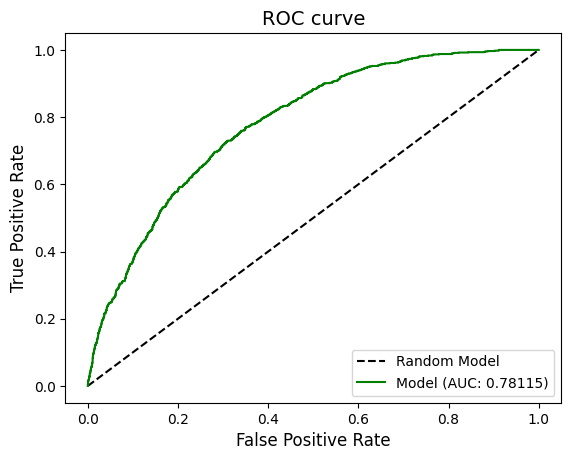

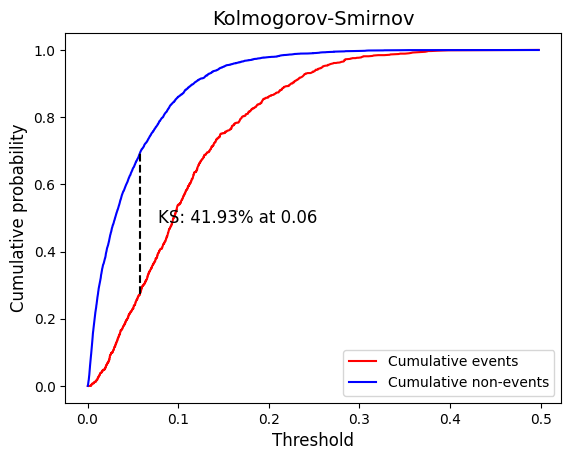

In [9]:
y_pred_train = scorecard.predict_proba(X_train)[:, 1]

plot_auc_roc(y_train, y_pred_train)
plt.show()

plot_ks(y_train, y_pred_train)
plt.show()

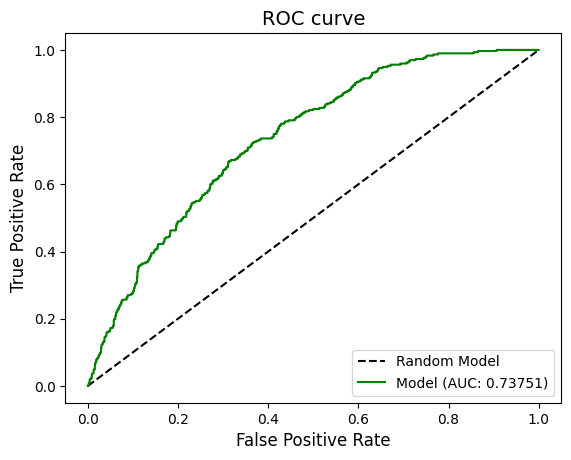

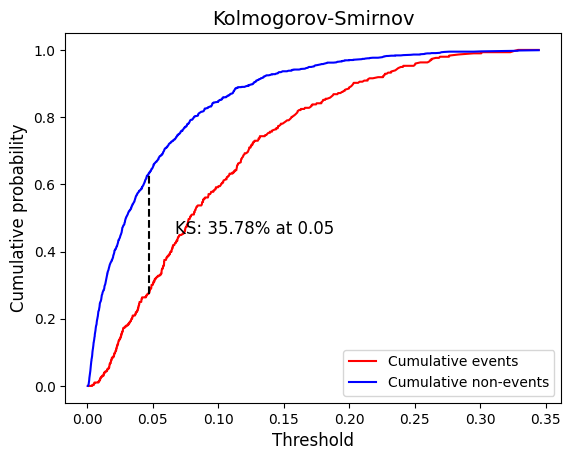

In [10]:
X_test = test[colnames]
y_test = test["bad"]

y_pred_test = scorecard.predict_proba(X_test)[:, 1]

plot_auc_roc(y_test, y_pred_test)
plt.show()

plot_ks(y_test, y_pred_test)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# Recreate canonical split (robust to running this chunk standalone)
accepts = pd.read_csv("Data/accepts.csv")
train_tmp, test_tmp = train_test_split(accepts, test_size=0.25, random_state=1234)

test_final = test_tmp.copy()

# Ensure weight exists
if "weight" not in test_final.columns:
    test_final["weight"] = 1.0

# Score using the fitted optbinning scorecard and the predictor list `colnames`
test_final["score"] = scorecard.score(test_final[colnames])

test_final[["score", "bad"]].head()

,score,bad
3077,582.386242,0
5046,579.323917,0
3224,528.357225,0
46,621.439842,0
1771,609.618218,0


In [12]:
good_weight = 4.75

test_final["decile"] = pd.qcut(test_final["score"], 10, labels=False)

# Counts by decile
bad_ct = test_final.loc[test_final["bad"] == 1].groupby("decile").size()
good_ct = test_final.loc[test_final["bad"] == 0].groupby("decile").size()

# Align indices to ensure 0..9 exist
all_dec = pd.Index(range(10), name="decile")
bad_ct = bad_ct.reindex(all_dec, fill_value=0)
good_ct = good_ct.reindex(all_dec, fill_value=0)

PD = bad_ct / (good_ct * good_weight + bad_ct)
PD

decile
0    0.151498
1    0.107125
2    0.078358
3    0.068966
4    0.053703
5    0.028754
6    0.047579
7    0.021841
8    0.005895
9    0.001450
dtype: float64

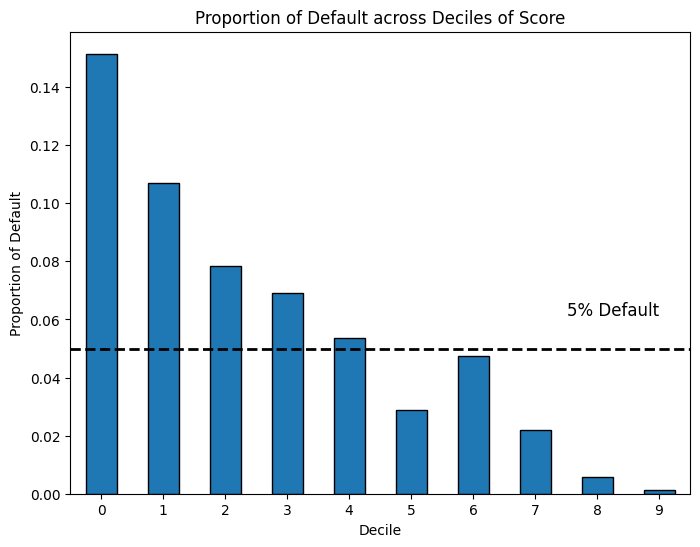

In [13]:
plt.figure(figsize=(8, 6))
PD.plot(kind="bar", edgecolor="black")
plt.axhline(y=0.05, color="black", linestyle="--", linewidth=2)
plt.text(x=9, y=0.06, s="5% Default", color="black", ha="right", va="bottom", fontsize=12)

plt.title("Proportion of Default across Deciles of Score")
plt.xlabel("Decile")
plt.ylabel("Proportion of Default")
plt.xticks(rotation=0)
plt.show()

In [14]:
rejects_path = "Data/rejects.csv"

if os.path.exists(rejects_path):
    rejects = pd.read_csv(rejects_path)

    # Ensure the rejects file has the predictor columns needed
    missing = [c for c in colnames if c not in rejects.columns]
    if missing:
        raise ValueError(f"rejects.csv is missing required columns: {missing}")

    X_r = rejects[colnames].copy()
    rejects["y_pred"] = scorecard.predict_proba(X_r)[:, 1]

    cutoff = 0.06
    rejects["bad"] = (rejects["y_pred"] > cutoff).astype(int)

    rejects["weight"] = rejects["bad"].apply(lambda x: 4.75 if x == 0 else 1.0)
    rejects = rejects.drop(columns=["y_pred"])

    comb_hard = pd.concat([accepts, rejects.head(1876)], ignore_index=True)

    print("rejects loaded and combined. comb_hard shape:", comb_hard.shape)
    comb_hard.head()
else:
    print("No rejects.csv found — skipping reject inference section.")

rejects loaded and combined. comb_hard shape: (7713, 22)


In [15]:
def plot_default_and_acceptance_by_score(
    df: pd.DataFrame,
    score_col: str = "score",
    bad_col: str = "bad",
    weight_col: str | None = None,
    n_bins: int = 250,
    smooth_window: int | None = 9,
    title: str = "Default Rate by Acceptance Across Score",
):
    keep_cols = [score_col, bad_col] + ([weight_col] if weight_col else [])
    d = df[keep_cols].copy()
    d = d.dropna(subset=[score_col, bad_col])

    d[score_col] = pd.to_numeric(d[score_col], errors="coerce")
    d[bad_col] = pd.to_numeric(d[bad_col], errors="coerce").astype(int)

    if weight_col and weight_col in d.columns:
        d[weight_col] = pd.to_numeric(d[weight_col], errors="coerce").fillna(0.0)
    else:
        d["_w"] = 1.0
        weight_col = "_w"

    d = d.dropna(subset=[score_col, bad_col])

    # Bin scores to stabilize the curve
    q = min(n_bins, max(5, d.shape[0]))
    d["_bin"] = pd.qcut(d[score_col], q=q, duplicates="drop")
    d["_score_mid"] = d["_bin"].apply(lambda x: (x.left + x.right) / 2.0).astype(float)

    # Aggregate per bin using in-frame weights (avoids index alignment bugs)
    grp = d.groupby("_score_mid", as_index=False).apply(
        lambda g: pd.Series({
            "wt": float(g[weight_col].sum()),
            "bad_wt": float((g[bad_col] * g[weight_col]).sum())
        })
    ).reset_index(drop=True)

    grp = grp.sort_values("_score_mid", ascending=False).reset_index(drop=True)

    total_wt = grp["wt"].sum()
    grp["cum_wt"] = grp["wt"].cumsum()
    grp["cum_bad_wt"] = grp["bad_wt"].cumsum()

    grp["accept_rate_pct"] = 100.0 * grp["cum_wt"] / total_wt
    grp["default_rate_pct"] = 100.0 * grp["cum_bad_wt"] / grp["cum_wt"]

    if smooth_window and smooth_window > 1:
        grp["accept_rate_pct"] = grp["accept_rate_pct"].rolling(
            window=smooth_window, min_periods=1
        ).mean()
        grp["default_rate_pct"] = grp["default_rate_pct"].rolling(
            window=smooth_window, min_periods=1
        ).mean()

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(grp["_score_mid"], grp["default_rate_pct"], label="Default Rate (%)")
    ax1.set_xlabel("Scorecard Value")
    ax1.set_ylabel("Default Rate (%)")
    ax1.set_title(title)

    ax2 = ax1.twinx()
    ax2.plot(grp["_score_mid"], grp["accept_rate_pct"], label="Acceptance Rate (%)")
    ax2.set_ylabel("Acceptance Rate (%)")
    ax2.set_ylim(0, 100)

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.tight_layout()
    plt.show()
    return grp

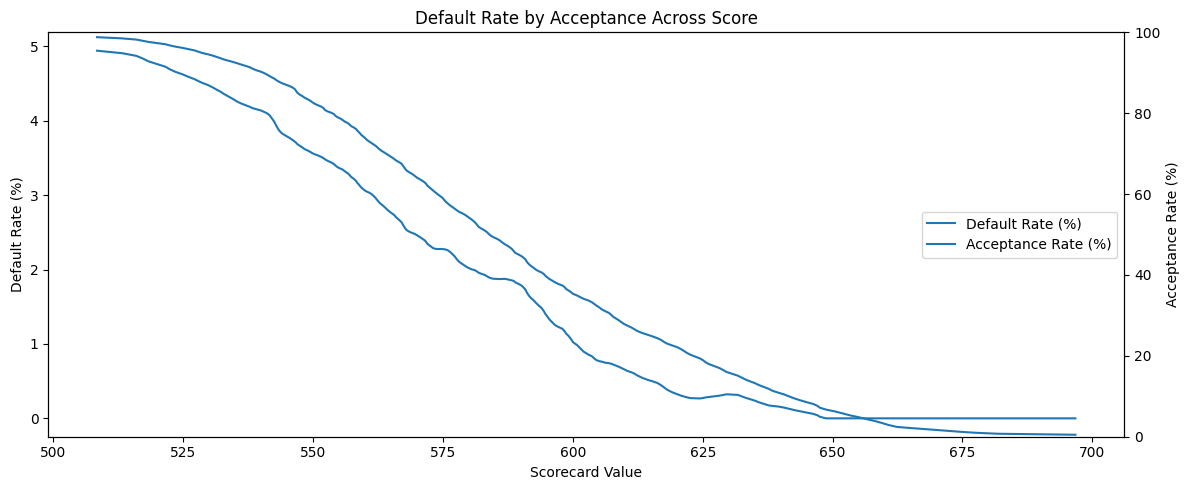

,_score_mid,wt,bad_wt,cum_wt,cum_bad_wt,accept_rate_pct,default_rate_pct
0,696.7435,28.5,0.0,28.5,0.0,0.489270,0.0
1,681.8875,28.5,0.0,57.0,0.0,0.733906,0.0
2,677.5145,28.5,0.0,85.5,0.0,0.978541,0.0
3,674.5585,28.5,0.0,114.0,0.0,1.223176,0.0
4,672.1945,28.5,0.0,142.5,0.0,1.467811,0.0


In [16]:
curve = plot_default_and_acceptance_by_score(
    test_final,
    score_col="score",
    bad_col="bad",
    weight_col="weight" if "weight" in test_final.columns else None,
    n_bins=250,
    smooth_window=9,
    title="Default Rate by Acceptance Across Score"
)

curve.head()

In [17]:
def plot_profit_and_acceptance_by_score(
    df: pd.DataFrame,
    score_col: str = "score",
    bad_col: str = "bad",
    weight_col: str | None = None,
    profit_if_good: float = 2000.0,
    loss_if_bad: float = 20000.0,
    n_bins: int = 250,
    smooth_window: int | None = 9,
    title: str = "Profit by Acceptance Across Score",
):
    """
    Plot cumulative expected Profit ($) vs Acceptance Rate (%) across score cutoffs.

    For each cutoff score c:
      accepted = rows with score >= c
      acceptance rate = accepted / total
      profit($) = sum_over_accepted( weight * (profit_if_good*(1-bad) - loss_if_bad*bad) )
    """
    keep_cols = [score_col, bad_col] + ([weight_col] if weight_col else [])
    d = df[keep_cols].copy()
    d = d.dropna(subset=[score_col, bad_col])

    d[score_col] = pd.to_numeric(d[score_col], errors="coerce")
    d[bad_col] = pd.to_numeric(d[bad_col], errors="coerce").astype(int)

    if weight_col and weight_col in d.columns:
        d[weight_col] = pd.to_numeric(d[weight_col], errors="coerce").fillna(0.0)
    else:
        d["_w"] = 1.0
        weight_col = "_w"

    d = d.dropna(subset=[score_col, bad_col])

    # Per-row profit contribution
    d["_profit"] = d[weight_col] * (profit_if_good * (1 - d[bad_col]) - loss_if_bad * d[bad_col])

    # Bin scores to stabilize the curve
    q = min(n_bins, max(5, d.shape[0]))
    d["_bin"] = pd.qcut(d[score_col], q=q, duplicates="drop")
    d["_score_mid"] = d["_bin"].apply(lambda x: (x.left + x.right) / 2.0).astype(float)

    # Aggregate per bin (index-safe)
    grp = d.groupby("_score_mid", as_index=False).apply(
        lambda g: pd.Series({
            "wt": float(g[weight_col].sum()),
            "profit": float(g["_profit"].sum()),
        })
    ).reset_index(drop=True)

    grp = grp.sort_values("_score_mid", ascending=False).reset_index(drop=True)

    total_wt = grp["wt"].sum()
    grp["cum_wt"] = grp["wt"].cumsum()
    grp["cum_profit"] = grp["profit"].cumsum()

    grp["accept_rate_pct"] = 100.0 * grp["cum_wt"] / total_wt

    # Optional smoothing (rolling mean)
    if smooth_window and smooth_window > 1:
        grp["accept_rate_pct"] = grp["accept_rate_pct"].rolling(
            window=smooth_window, min_periods=1
        ).mean()
        grp["cum_profit"] = grp["cum_profit"].rolling(
            window=smooth_window, min_periods=1
        ).mean()

    # Plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.plot(grp["_score_mid"], grp["cum_profit"], label="Profit ($)")
    ax1.set_xlabel("Scorecard Value")
    ax1.set_ylabel("Profit ($)")
    ax1.set_title(title)

    ax2 = ax1.twinx()
    ax2.plot(grp["_score_mid"], grp["accept_rate_pct"], label="Acceptance Rate (%)")
    ax2.set_ylabel("Acceptance Rate (%)")
    ax2.set_ylim(0, 100)

    # Combined legend on the right
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.tight_layout()
    plt.show()

    return grp

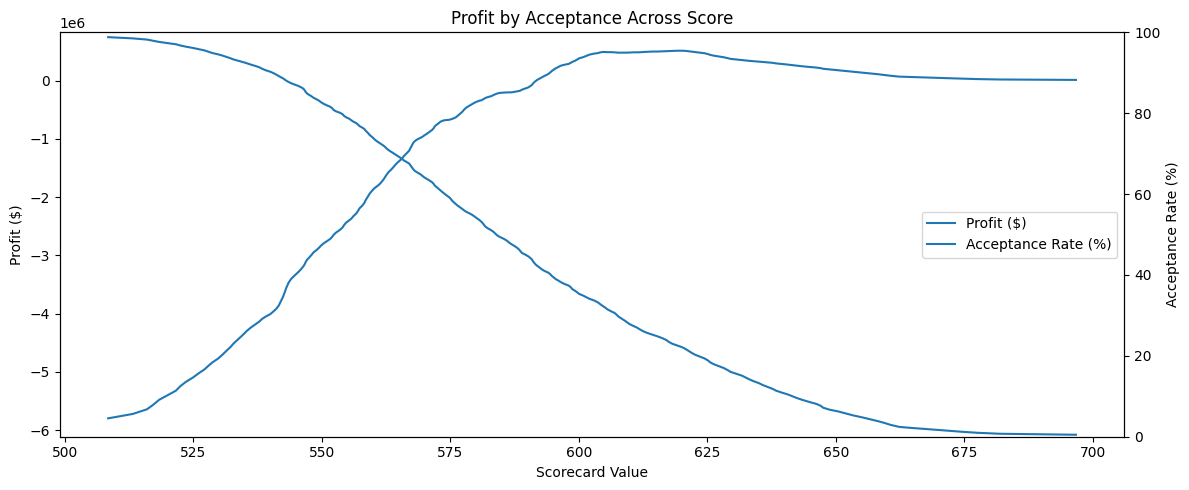

,_score_mid,wt,profit,cum_wt,cum_profit,accept_rate_pct
0,696.7435,28.5,14250.0,28.5,14250.0,0.489270
1,681.8875,28.5,14250.0,57.0,21375.0,0.733906
2,677.5145,28.5,14250.0,85.5,28500.0,0.978541
3,674.5585,28.5,14250.0,114.0,35625.0,1.223176
4,672.1945,28.5,14250.0,142.5,42750.0,1.467811


In [18]:
# Adjust these economics to match your business case:
profit_if_good = 500.0   # profit on a good loan
loss_if_bad    = 30000.0  # loss on a bad loan (positive number)

profit_curve = plot_profit_and_acceptance_by_score(
    test_final,
    score_col="score",
    bad_col="bad",
    weight_col="weight" if "weight" in test_final.columns else None,
    profit_if_good=profit_if_good,
    loss_if_bad=loss_if_bad,
    n_bins=250,
    smooth_window=9,
    title="Profit by Acceptance Across Score"
)

profit_curve.head()